In [2]:
import sys, os, yaml
sys.path.append('../')
import torch
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
from inverse_model import InverseModel
import argparse
from utils import visualize

device = torch.device('cuda:0')
plt.rcParams["font.family"] = "Times New Roman"

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
args = argparse.ArgumentParser().parse_args('')

project_dir = '../weights/case2_inverse_params_a'
config = '../config/case2_inverse_param_a.yaml'

model_dir = os.path.join(project_dir, 'best_train_loss_model.pt')

with open(config, 'r') as f:
    config = yaml.safe_load(f)
    for key, value in config.items():
        setattr(args, key, value)
        
epoch = 200
lr = 0.1
run = 5
batch_size = 100
regl_case = 'blade_case2_free'

setattr(args, 'eval_type', 'inverse_eval')
setattr(args, 'epoch', epoch)
setattr(args, 'lr', lr)
setattr(args, 'run', run)
setattr(args,'seed', None)
setattr(args, 'bs', batch_size)
setattr(args, 'regl_case', regl_case)
setattr(args, 'project_dir', project_dir)

print(args)
evaluator = InverseModel(args)
evaluator.create_eval_dir()
evaluator.load_weights()

case_label =     ['1', '2', '3', '4', '7', '10', '5', '6', '8', '9']
case_label_dic = ['R', 'D', 'E', 'F', 'I', 'L',  'G', 'H', 'J', 'K']

Namespace(batch_size=64, bs=100, data_case='blade', decode_mode='linear', depth=4, epoch=200, eval_type='inverse_eval', id_test_dataset='../data/case2_iid_test.pkl', input_dim=200, iterative_epoch_list=None, loss_mode='NRMSE', lr=0.1, model_type='ParametricDeepONet', noised_data=False, ood_test_dataset='../data/case2_ood_test.pkl', optimizer='Adam', params_dim=3, pebasis=50, print_every=100, project_dir='../weights/case2_inverse_params_a', regl_case='blade_case2_free', run=5, save_in='../weights/case2_params_a', seed=None, solution_num=1, test_dataset=None, train_dataset='../data/case2_train.pkl', width=400)
The model is set to be:  ParametricDeepONet
The decoder mode is:  linear
The depth of the model is:  4
The width of the model is:  400
Normalizing the data mode is self_min_max...
Train data is normalized by the train data...
The shape of train dataset: source_signal, params_data, response_data, ts... torch.Size([600, 1, 200]) torch.Size([600, 3]) torch.Size([600, 4, 200]) torch.Si

In [4]:
total_train_params = []
for i in range(run):
    print("training data run: ", i)
    pred_train_params = evaluator.gradient_init(data=evaluator.train_data, batch_size=100, epoch=epoch, forward_net = evaluator.model, regl_case=regl_case, lr=lr, data_case = 'case2')
    total_train_params.append(pred_train_params)

mean_train_params = torch.mean(torch.stack(total_train_params), dim=0)
std_train_pred_params = torch.std(torch.stack(total_train_params), dim=0)
post_pi_data = mean_train_params, evaluator.train_data[0], evaluator.train_data[1], evaluator.train_data[2], evaluator.train_data[3]
evaluator.post_pi_train_data = post_pi_data
evaluator.post_pi_train_dataset = torch.utils.data.TensorDataset(post_pi_data[0], post_pi_data[1], post_pi_data[2], post_pi_data[3], post_pi_data[4])

total_test_params = []
for i in range(run):
    print("test data run: ", i)
    pred_test_params = evaluator.gradient_init(data=evaluator.test_data, batch_size=100, epoch=epoch, forward_net=evaluator.model, regl_case=regl_case, lr=lr, data_case = 'case2')
    total_test_params.append(pred_test_params)
    
mean_test_params = torch.mean(torch.stack(total_test_params), dim=0)
std_test_pred_params = torch.std(torch.stack(total_test_params), dim=0)
post_pi_data = mean_test_params, evaluator.test_data[0], evaluator.test_data[1], evaluator.test_data[2], evaluator.test_data[3]
evaluator.post_pi_test_data = post_pi_data

training data run:  0


training data run:  1
training data run:  2
training data run:  3
training data run:  4
test data run:  0
test data run:  1
test data run:  2
test data run:  3
test data run:  4


Normalized RMSE of train mu:  tensor(0.4598, device='cuda:0', grad_fn=<SqrtBackward0>)
Normalized RMSE of test mu:  tensor(0.4027, device='cuda:0', grad_fn=<SqrtBackward0>)


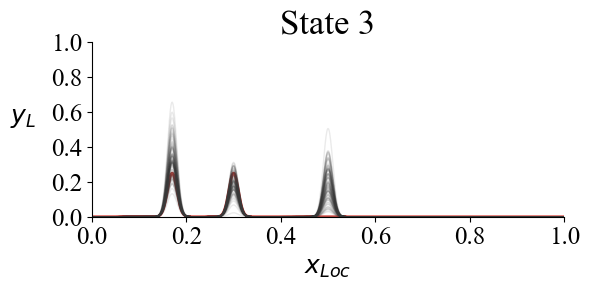

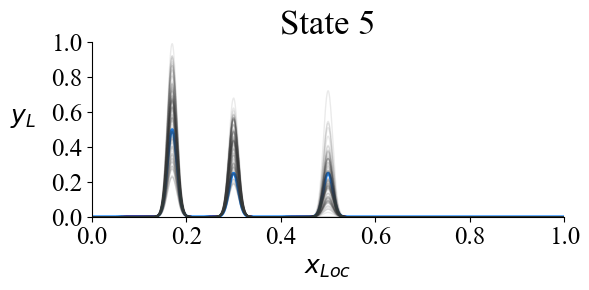

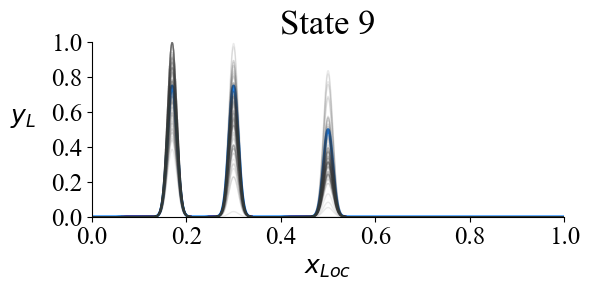

In [5]:
metrics = evaluator.evaluate_metrics(case='blade', mode='GI')
metrics = evaluator.evaluate_metrics(case='blade', mode='GI', data='test')

train_list = [2]
for i in train_list:
    visualize.plot_para_gaussian(case=case_label[i], mu_test=evaluator.test_data[1][100*i:100*(i+1), :],
                                 pred_mu_test=mean_test_params[100*i:100*(i+1), :], save_as=os.path.join(evaluator.save_dir, './gi_shape_label_{}.png'.format(case_label[i])))

test_list = [0, 3]
for i in test_list:
    j = i + 6
    visualize.plot_para_gaussian(case=case_label[j], mu_test=evaluator.test_data[1][100*j:100*(j+1), :],
                                 pred_mu_test= mean_test_params[100*j:100*(j+1), :], save_as = os.path.join(evaluator.save_dir, './gi_shape_label_{}.png'.format(case_label[j])))

In [6]:
import models.inverse_net

post_train_data_loader = torch.utils.data.DataLoader(evaluator.post_pi_train_dataset, batch_size=64, shuffle=True, generator=torch.Generator(evaluator.device))
    
epoch = 50
iterative_steps = 1
iter_memory = 0
lr = 0.001
run = 1

class IRNet(models.inverse_net.InitialRefineNet):
    def __init__(self):
        super(IRNet, self).__init__()
        self.gradient_nn = dde.nn.FNN([(iter_memory + 2) * 3, 128, 128, (iter_memory+1) * 3], 'relu', 'Glorot normal')

record = {}
record['train_refine_loss'], record['test_refine_loss'] = [], []
regl_case = ''
for _ in range(run):
    inverse_refine_net = IRNet()
    optimizer = torch.optim.Adam(inverse_refine_net.parameters(), lr=lr)


    evaluator.iterative_refine(ir_net = inverse_refine_net, 
                                optimizer = optimizer,
                                forward_model = evaluator.model, 
                                data_loader= post_train_data_loader,
                                check_int = 1, epochs = epoch, iter_steps = iterative_steps, memory_iter = iter_memory, regl_case = regl_case, data_case='case2', data_source='train', use_evaluate_mode = True)
    
    record['train_refine_loss'].append(evaluator.evaluate_record['train_refine_loss'])
    record['test_refine_loss'].append(evaluator.evaluate_record['test_refine_loss'])
np.save(os.path.join(evaluator.save_dir, 'use_forward_gradient_record.npy'), record)

In [7]:
test_mu_refine, _ = evaluator.iteratively_update_mu(forward_model = evaluator.model, ir_net= inverse_refine_net, x_t = evaluator.post_pi_test_data[1], mu_hat_0= evaluator.post_pi_test_data[0] , y_t = evaluator.post_pi_test_data[3], ts = evaluator.post_pi_test_data[4], 
                                                    iter_steps = iterative_steps, memory_iter = iter_memory, regl_case = regl_case)
train_mu_refine, _ = evaluator.iteratively_update_mu(forward_model = evaluator.model, ir_net= inverse_refine_net, x_t = evaluator.post_pi_train_data[1], mu_hat_0= evaluator.post_pi_train_data[0] , y_t = evaluator.post_pi_train_data[3], ts = evaluator.post_pi_train_data[4], 
                                                     iter_steps = iterative_steps, memory_iter = iter_memory, regl_case = regl_case)

Normalized RMSE of train mu:  tensor(0.2556, device='cuda:0', grad_fn=<SqrtBackward0>)
Normalized RMSE of test mu:  tensor(0.3113, device='cuda:0', grad_fn=<SqrtBackward0>)


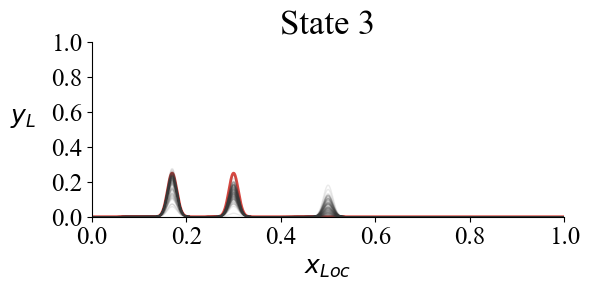

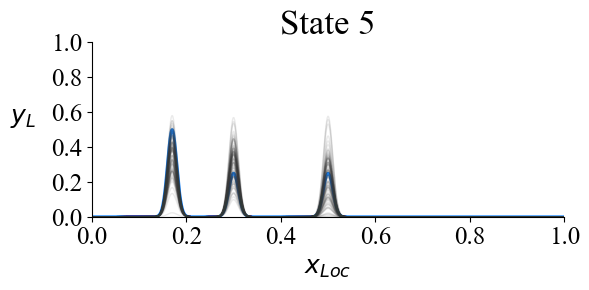

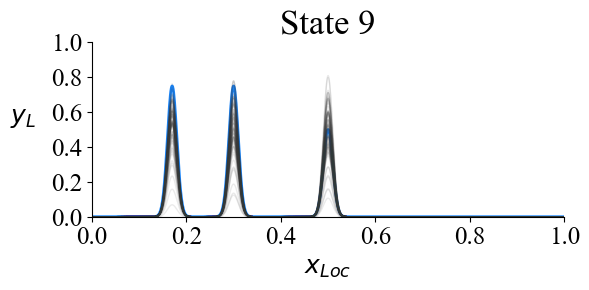

In [9]:
metrics = evaluator.evaluate_metrics(case = 'blade', mode='NR')
metrics = evaluator.evaluate_metrics(case = 'blade', mode='NR', data = 'test')
train_list = [2]
for i in train_list:
        visualize.plot_para_gaussian(case = case_label[i],mu_test = evaluator.test_data[1][100*i:100*(i+1), :],
                         pred_mu_test= test_mu_refine[100*i:100*(i+1), :], save_as =  os.path.join(evaluator.save_dir,'./nr_shape_label_{}.png'.format(case_label[i])))
        
test_list = [0, 3]
for i in test_list:
        j = i + 6
        visualize.plot_para_gaussian(case = case_label[j], mu_test = evaluator.test_data[1][100*j:100*(j+1), :],
                         pred_mu_test= test_mu_refine[100*j:100*(j+1), :], save_as = os.path.join(evaluator.save_dir,'./nr_shape_label_{}.png'.format(case_label[j])))